## Environment Setup
Let's first setup our environment
- Install all required libraries
- Initialise some constants
- Import the CIFAR10 dataset (in my case I already have it installed)
The CIFAR10 dataset is images so we have to apply a transform to turn the images into tensors

In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data.dataloader import DataLoader

NUM_CLASSES = 10
BATCH_SIZE = 10
IMAGE_DIM = 32
NUM_CHANNELS = 3
KERNEL_SIZE = 3

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), 
     torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))])
training_dataset = torchvision.datasets.CIFAR10('./data', train=True, transform=transform)
testing_dataset = torchvision.datasets.CIFAR10('./data', train=False, transform=transform)

## Setting up the Network Class
Now onto the main part: Defining our network class
I like to encapsulate and abstract everything into classes so I decided to keep everything (including the training loop) in the network class. 

In [11]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        #Define Layers
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, (3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, (3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, (3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(2048, 64),
            nn.ReLU(),
            nn.Linear(64, NUM_CLASSES),
            nn.Softmax(-1)
        )
        self.training_losses = []
        self.validation_losses = []
    
    def __forward(self, input):
        output = self.network.forward(input)
        return output

    def __accuracy(self, testing_data_loader):
        #Get accuracy on test dataset (just percentage of correct responses)
        for idx, batch in enumerate(testing_data_loader):
            correct = 0
            total = 0
            inputs, labels = batch
            preds = self.__forward(inputs)
            for pred, label in zip(preds, labels):
                if torch.argmax(pred) == label:
                    correct += 1
                total += 1
            return (100 * correct / total)
        
    def predict(self, input):
        return(self.__forward(input))
    
    def train_network(self, training_data_loader, testing_data_loader, epochs, lr, device="cpu"):

        optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        loss_fn = nn.CrossEntropyLoss()

        #Iterate for epochs
        for epoch in range(epochs):
            print(f"Epoch Number {epoch}")

            #Set model in train mode
            self.train()

            total_loss = 0
            #Go through every loss
            for idx, batch in enumerate(training_data_loader):
                #Reset gradients
                optimizer.zero_grad()

                inputs, labels = batch
                inputs = inputs.to(device).to(torch.float32)
                labels = labels.to(device)
                
                #Get predictions and calculate loss
                preds = self.__forward(inputs)
                loss = loss_fn(preds, labels)

                #Calculate loss gradients by backpropagating
                loss.backward()

                #Update model weights and biases
                optimizer.step()

                total_loss += loss.item()
                
            #Get validation loss
            self.eval()
            with torch.no_grad():
                val_input, val_target = next(iter(test_data_loader))
                val_output = self.__forward(val_input)
                val_loss = loss_fn(val_output, val_target)
                print(f"Loss: {round((total_loss/BATCH_SIZE), 2)}  Val Loss: {round(val_loss.item(), 2)}")

                #Get and print accuracy
                accuracy = self.__accuracy(testing_data_loader)
                print(f"Accuracy {round(accuracy, 2)}%")

                #Append val and train loss to list to use to plot later
                self.training_losses.append(total_loss/BATCH_SIZE)
                self.validation_losses.append(val_loss.item())


## Dataloaders :)
Create PyTorch dataloaders from our train and test datasets. The dataloaders make it so much easier to handle batches.

In [16]:
TEST_DATASET_LEN = 10000

train_data_loader = DataLoader(training_dataset, BATCH_SIZE, True, num_workers=2)
test_data_loader = DataLoader(testing_dataset, TEST_DATASET_LEN, False)

## Start Training!
We can declare an instance of our network and begin training with just one line of code

In [18]:
EPOCHS = 50
LEARNING_RATE = 7e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
    
cnn_network = Network().to(device)
cnn_network.train_network(train_data_loader, test_data_loader, EPOCHS, LEARNING_RATE, device)

Epoch Number 0
Loss: 1133.39  Val Loss: 2.18
Accuracy 27.04%
Epoch Number 1
Loss: 1075.0  Val Loss: 2.11
Accuracy 35.16%
Epoch Number 2
Loss: 1047.35  Val Loss: 2.06
Accuracy 41.0%
Epoch Number 3
Loss: 1026.35  Val Loss: 2.02
Accuracy 44.12%
Epoch Number 4
Loss: 1011.24  Val Loss: 2.0
Accuracy 46.44%
Epoch Number 5
Loss: 995.65  Val Loss: 1.98
Accuracy 48.33%
Epoch Number 6
Loss: 981.09  Val Loss: 1.94
Accuracy 51.86%
Epoch Number 7
Loss: 967.98  Val Loss: 1.93
Accuracy 52.82%
Epoch Number 8
Loss: 956.26  Val Loss: 1.89
Accuracy 56.95%
Epoch Number 9
Loss: 946.92  Val Loss: 1.88
Accuracy 58.53%
Epoch Number 10
Loss: 936.33  Val Loss: 1.87
Accuracy 58.85%
Epoch Number 11
Loss: 928.92  Val Loss: 1.85
Accuracy 61.71%
Epoch Number 12
Loss: 920.63  Val Loss: 1.84
Accuracy 62.09%
Epoch Number 13
Loss: 913.4  Val Loss: 1.82
Accuracy 64.05%
Epoch Number 14
Loss: 906.75  Val Loss: 1.82
Accuracy 64.45%
Epoch Number 15
Loss: 900.57  Val Loss: 1.8
Accuracy 66.09%
Epoch Number 16
Loss: 895.42  Val 

## Part 2: Visualization
Let's import pyplot from matplotlib and visualize our training and validation losses over epochs

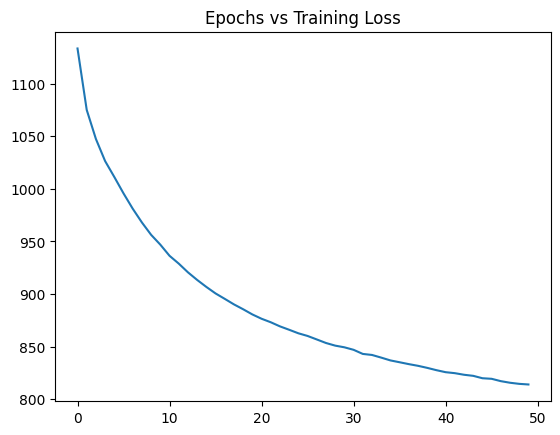

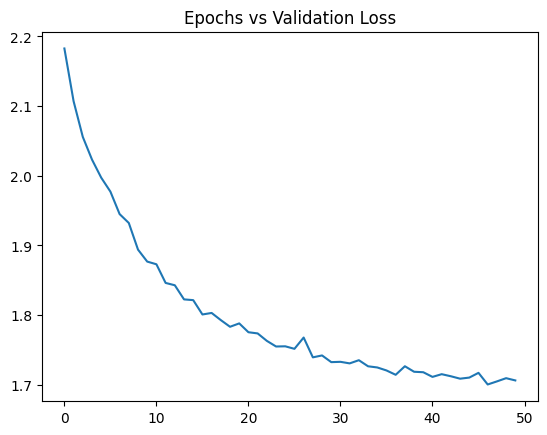

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(EPOCHS), cnn_network.training_losses, label="Training Loss")
plt.title("Epochs vs Training Loss")
plt.show()
plt.plot(np.arange(EPOCHS), cnn_network.validation_losses, label="Validation Loss")
plt.title("Epochs vs Validation Loss")
plt.show()

## Save our model weights
So we don't have to wait to use it next time

In [24]:
torch.save(cnn_network.state_dict(), "./cnn.pth")

# That's It!!
More Possible Steps
- Optimizer Hyperparameters (epochs, batchsize, learning rate)
- Change layer parameters (change kernel or size for conv layer)
- Change Newtork Architecture (Add conv layers or linear layers)
